# Milestone 01
# Peter Lorenz

## 0. Preliminaries

Import the required libraries:

In [3]:
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn.feature_selection import RFE # Recursive Feature Elimination
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mutual_info_score

Set global options:

In [4]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do not truncate numpy arrays
np.set_printoptions(threshold=sys.maxsize)

Declare constants:

In [5]:
# Number of bins for computing mutual information score
MI_BINS = 20

Declare utility functions:

In [6]:
# Compute mutual information score between given column and the target variable
def calc_MI(df, target_arr, col):
    c_xy = np.histogram2d(df[col], target_arr, MI_BINS)[0]
    mi = mutual_info_score(None, None, contingency = c_xy)
    
    # Return tuple of column name and MI score vs. target
    return (col, round(mi, 3))

# Display kernel density plot for the given column with options
def show_kde_plot(df, col, axis):
    # Compute rough bandwidth "factor" from range
    bandwidth = np.ptp(df[col]) / 50

    # Display plot and labels
    sns.kdeplot(df.loc[:, col], ax = axis, bw = bandwidth)
    axis.set_xlabel(col) # Set text for the x axis
    axis.set_ylabel('Density')# Set text for y axis

## 1. Refine data understanding / Prepare DFD of solving the manufacturing quality problem
In this section we refine our understanding of the data and prepare a dataflow diagram that describes a potential solution to the manufacturing quality problem.

<img src="https://github.com/pelorenz/data-science-420/raw/master/M01-PeterLorenz-DFD.jpg">

## 2. Read and merge data
First we import the sensor data set and its accompanying labels, generating column names as necessary for convenient reference to specific features:

In [7]:
# Internet location of the data set and labels
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

# Download sensor data and labels into a dataframe object, specify python engine for regex
sensor_data = pd.read_csv(url, sep='\s{1,}', engine='python')
sensor_labels_data = pd.read_csv(labels_url, sep='\s{1,}', engine='python')

# Generate index-based column names for the sensor data set
sensor_data.columns = list('s' + str(idx + 1) for idx in range(0, sensor_data.shape[1]))

# Assign column names to the labels
sensor_labels_data.columns = ['result', 'date', 'time']

# Save the original data frame for future reference as we modify its contents
sensor_data_orig = sensor_data

# Display shape and initial values of the sensor data set
print('Sensor data set:')
sensor_data.shape
sensor_data.head()

# Display shape and data for labels
print('Sensor labels:')
sensor_labels_data.shape
sensor_labels_data.head()

Sensor data set:


(1566, 590)

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s581,s582,s583,s584,s585,s586,s587,s588,s589,s590
0,3095.780,2465.140,2230.422,1463.661,0.829,100.000,102.343,0.125,1.497,-0.001,...,0.006,208.204,0.502,0.022,0.005,4.445,0.010,0.020,0.006,208.204
1,2932.610,2559.940,2186.411,1698.017,1.510,100.000,95.488,0.124,1.444,0.004,...,0.015,82.860,0.496,0.016,0.004,3.175,0.058,0.048,0.015,82.860
2,2988.720,2479.900,2199.033,909.793,1.320,100.000,104.237,0.122,1.488,-0.012,...,0.004,73.843,0.499,0.010,0.003,2.054,0.020,0.015,0.004,73.843
3,3032.240,2502.870,2233.367,1326.520,1.533,100.000,100.397,0.123,1.503,-0.003,...,nan,nan,0.480,0.477,0.104,99.303,0.020,0.015,0.004,73.843
4,2946.250,2432.840,2233.367,1326.520,1.533,100.000,100.397,0.123,1.529,0.017,...,0.005,44.008,0.495,0.019,0.004,3.828,0.034,0.015,0.005,44.008


Sensor labels:


(1566, 3)

,result,date,time
0,-1,"""19/07/2008","12:32:00"""
1,1,"""19/07/2008","13:17:00"""
2,-1,"""19/07/2008","14:43:00"""
3,-1,"""19/07/2008","15:22:00"""
4,-1,"""19/07/2008","17:53:00"""


## 3. Clean and prepare data
We begin by examining the data types:

In [8]:
# List columns with data types
sensor_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 590 columns):
 #   Column  Dtype  
---  ------  -----  
 0   s1      float64
 1   s2      float64
 2   s3      float64
 3   s4      float64
 4   s5      float64
 5   s6      float64
 6   s7      float64
 7   s8      float64
 8   s9      float64
 9   s10     float64
 10  s11     float64
 11  s12     float64
 12  s13     float64
 13  s14     float64
 14  s15     float64
 15  s16     float64
 16  s17     float64
 17  s18     float64
 18  s19     float64
 19  s20     float64
 20  s21     float64
 21  s22     float64
 22  s23     float64
 23  s24     float64
 24  s25     float64
 25  s26     float64
 26  s27     float64
 27  s28     float64
 28  s29     float64
 29  s30     float64
 30  s31     float64
 31  s32     float64
 32  s33     float64
 33  s34     float64
 34  s35     float64
 35  s36     float64
 36  s37     float64
 37  s38     float64
 38  s39     float64
 39  s40     float64
 40  s41  

All of the columns are float64, so there are no categorical columns to one-hot encode and no casting is needed.
### Remove columns with too many NaN's
Now we look for missing data by finding the number of columns containing at least one NaN:

In [9]:
# Display number of columns with NaN in sensor data set
print("Number of columns with NaN:", len(sensor_data.columns[sensor_data.isna().any()]))

Number of columns with NaN: 534



Most columns have at least one NaN. What we must decide is at what point to drop a column because it has too much missing data, balancing the cost of dropping columns against the cost of having columns with a significant proportion of imputed values. For a sense of the extent of the problem, we count the number of columns with greater than 5% and 10% NaN's respectively:

In [10]:
# Count NaN's per column
df_na = sensor_data.isna().sum()

# Identify and display columns above various cutoff percentages of NaN's
nan_1_pct = df_na[df_na > 0.01 * sensor_data.shape[0]]
nan_3_pct = df_na[df_na > 0.03 * sensor_data.shape[0]]
nan_5_pct = df_na[df_na > 0.05 * sensor_data.shape[0]]
nan_10_pct = df_na[df_na > 0.1 * sensor_data.shape[0]]
nan_20_pct = df_na[df_na > 0.2 * sensor_data.shape[0]]

print(nan_1_pct.shape[0], 'columns are more than 1% NaN')
print(nan_3_pct.shape[0], 'columns are more than 3% NaN')
print(nan_5_pct.shape[0], 'columns are more than 5% NaN')
print(nan_10_pct.shape[0], 'columns are more than 10% NaN')
print(nan_20_pct.shape[0], 'columns are more than 20% NaN')

103 columns are more than 1% NaN
60 columns are more than 3% NaN
52 columns are more than 5% NaN
52 columns are more than 10% NaN
32 columns are more than 20% NaN


There seems to be a space between 3% and 20% that separates columns with a manageable proportion of NaN's and columns where imputing NaN's might be expected to impact the results. So we drop the 52 columns 6% or more of whose values are NaN:

In [11]:
# Drop columns with more than 5% NaN's
sensor_data = sensor_data.drop(list(nan_5_pct.index), axis=1)
sensor_data.shape

(1566, 538)

We can see that 52 columns were dropped, leaving 538 columns in the dataframe:

In [12]:
# Display status after dropping zero-variance columns
print('Number of columns dropped:', nan_5_pct.shape[0])
print('Columns retained in data frame:', len(sensor_data.columns))

Number of columns dropped: 52
Columns retained in data frame: 538


### Impute fields with Nan in remaining columns
We now impute missing values in the remaining NaN columns (columns with 5% or less of NaN) using the median value of the column:

In [13]:
# Impute and replace missing values using column median
sensor_data = sensor_data.replace('?', np.NaN).apply(lambda x: x.fillna(x.median()))

# Verify imputation of missing values
print('Number of columns with NaN:', len(sensor_data.columns[sensor_data.isna().any()]))

Number of columns with NaN: 0


Our data set is now free of missing values that were initially encoded as NaN.
### Remove columns with zero variance
Another problem in the data set is features whose variance is zero, i.e. they have the same value in every row. This problem became apparent when I attempted to run seaborn's kdeplot function and received the warning: "Data must have variance to compute a kernel density estimate." So another step in cleaning the data is to drop columns with zero variance. Many of these columns are all zeros, though some have other constant values (e.g. s6 == 100). To address this, we identify and drop columns whose variance is zero:

In [14]:
# Display columns with zero variance
zero_variance_cols = np.array(sensor_data.columns[sensor_data.var() == 0])
print('Columns with zero variance:')
zero_variance_cols

# Drop columns with zero variance
sensor_data = sensor_data.drop(zero_variance_cols, axis=1)

array(['s6', 's14', 's43', 's50', 's53', 's70', 's98', 's142', 's150',
       's179', 's180', 's187', 's190', 's191', 's192', 's193', 's194',
       's195', 's227', 's230', 's231', 's232', 's233', 's234', 's235',
       's236', 's237', 's238', 's241', 's242', 's243', 's244', 's257',
       's258', 's259', 's260', 's261', 's262', 's263', 's264', 's265',
       's266', 's267', 's277', 's285', 's314', 's315', 's316', 's323',
       's326', 's327', 's328', 's329', 's330', 's331', 's365', 's370',
       's371', 's372', 's373', 's374', 's375', 's376', 's379', 's380',
       's381', 's382', 's395', 's396', 's397', 's398', 's399', 's400',
       's401', 's402', 's403', 's404', 's405', 's415', 's423', 's450',
       's451', 's452', 's459', 's462', 's463', 's464', 's465', 's466',
       's467', 's482', 's499', 's502', 's503', 's504', 's505', 's506',
       's507', 's508', 's509', 's510', 's513', 's514', 's515', 's516',
       's529', 's530', 's531', 's532', 's533', 's534', 's535', 's536',
      

We can check that 116 columns were dropped, leaving 422 columns in the dataframe:

In [15]:
# Display status after dropping zero-variance columns
print('Number of columns dropped:', len(zero_variance_cols))
print('Columns retained in data frame:', len(sensor_data.columns))

Number of columns dropped: 116
Columns retained in data frame: 422


### Remove columns with substantial percentage of zeros
Another form missing values can take is columns that primarily consist of zeros. As we did with NaN's, let's find the number columns consisting of various percentages of zeros:

In [16]:
# Count zeroes per column
zero_counts = sensor_data[sensor_data == 0].count(axis=0)

# Identify and display columns above various cutoff percentages of zeros
zero_1_pct = zero_counts[zero_counts > 0.01 * sensor_data.shape[0]]
zero_3_pct = zero_counts[zero_counts > 0.03 * sensor_data.shape[0]]
zero_5_pct = zero_counts[zero_counts > 0.05 * sensor_data.shape[0]]
zero_10_pct = zero_counts[zero_counts > 0.1 * sensor_data.shape[0]]
zero_20_pct = zero_counts[zero_counts > 0.2 * sensor_data.shape[0]]

print(zero_1_pct.shape[0], 'columns are more than 1% zeros')
print(zero_3_pct.shape[0], 'columns are more than 3% zeros')
print(zero_5_pct.shape[0], 'columns are more than 5% zeros')
print(zero_10_pct.shape[0], 'columns are more than 10% zeros')
print(zero_20_pct.shape[0], 'columns are more than 20% zeros')

46 columns are more than 1% zeros
43 columns are more than 3% zeros
33 columns are more than 5% zeros
29 columns are more than 10% zeros
21 columns are more than 20% zeros


Since it is possible that zero is a legitimate value in many cases (unlike NaN), we take a more conservative approach, discarding columns that are more than 20% zeros:

In [17]:
# Drop columns with more than 20% zeros
sensor_data = sensor_data.drop(list(zero_20_pct.index), axis=1)
sensor_data.shape

(1566, 401)

We can see that 21 columns were dropped, leaving 401 columns in the dataframe:

In [18]:
# Display status after dropping zero-variance columns
print('Number of columns dropped:', zero_20_pct.shape[0])
print('Columns retained in data frame:', len(sensor_data.columns))

Number of columns dropped: 21
Columns retained in data frame: 401


Our data set is now free of two common forms of missing values. We also verify that the *labels* data containing our target variable is free of missing values by displaying the number of columns with missing values:

In [19]:
# Display number of columns with NaN in sensor labels
print("Number of columns with NaN:", 
      len(sensor_labels_data.columns[sensor_labels_data.isna().any()]))

Number of columns with NaN: 0


Since neither the main data set nor the labels data set contains missing values, we can now proceed to data exploration.

## 4. Explore data visually
Next we explore the data visually to gain insight into how to approach creating a model. With so many features (590), the challenge of course is to display potential issues in the data and promising relationships between variables in a way that does not overwhelm the viewer.

We begin by examining the distributions of the variables, performing kernel density analysis on the remaining columns:

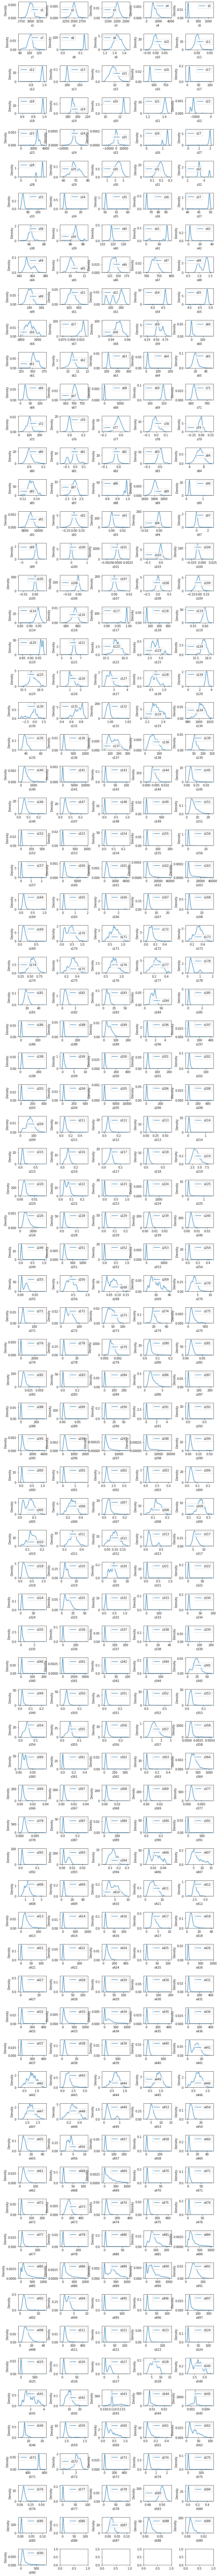

In [20]:
# Display kernel density plot for each feature
# Basically, this code divides up a subplot area based on the number of columns
# then assigns one plot to each area to fit all plots in a reasonable area
df_cols = len(sensor_data.columns)
COLS = 5
ROWS = int((df_cols - 1) / 5 + 1)
FIRST_COL = 1
LAST_COL = COLS * ROWS
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(12, ROWS * 2))
plt.subplots_adjust(wspace=0.5, hspace=1)

cur_col = 0
for i in range(FIRST_COL, LAST_COL + 1):
    if cur_col == len(sensor_data.columns):
        break
    row = int((i - 1) / COLS)
    col = (i - 1) % COLS
    col_name = sensor_data.columns[[cur_col]][0]
    cur_col = cur_col + 1
    try:
        show_kde_plot(sensor_data, col_name, axes[row][col])
    except Exception as e:
        print('Col ', col_name, ' error, col type = ', sensor_data[col_name].values.dtype)
        print('Range of column is ', str(np.ptp(sensor_data[col_name])))
        print('Standard deviation is ', str(np.std(sensor_data[col_name])))
        print('Variance is ', str(np.var(sensor_data[col_name])))
        print(e)

Next we look at the relationships between the columns, starting with the correlation matrix:

In [44]:
corr = sensor_data.corr().round(2)
corr

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s581,s582,s583,s584,s585,s586,s587,s588,s589,s590
s1,1.000,-0.140,0.000,-0.010,-0.010,nan,0.000,0.030,-0.050,0.010,...,-0.060,-0.040,0.000,0.020,0.020,0.020,0.020,-0.030,-0.030,0.000
s2,-0.140,1.000,0.010,-0.010,-0.000,nan,-0.020,-0.010,0.030,0.020,...,0.050,0.060,0.040,0.000,-0.000,0.000,-0.010,0.020,0.010,0.040
s3,0.000,0.010,1.000,0.300,0.100,nan,-0.140,-0.150,0.020,0.020,...,-0.000,0.010,-0.010,0.020,0.020,0.020,-0.030,-0.030,-0.030,-0.030
s4,-0.010,-0.010,0.300,1.000,-0.060,nan,-0.690,0.090,-0.100,0.070,...,-0.030,-0.050,0.010,0.030,0.020,0.030,0.040,-0.040,-0.030,-0.080
s5,-0.010,-0.000,0.100,-0.060,1.000,nan,-0.070,-0.340,-0.030,0.050,...,-0.030,0.100,0.040,-0.000,-0.000,-0.000,-0.040,-0.030,-0.030,0.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s586,0.020,0.000,0.020,0.030,-0.000,nan,-0.040,0.010,0.020,-0.040,...,0.000,0.000,-0.200,1.000,1.000,1.000,0.000,-0.000,-0.000,-0.000
s587,0.020,-0.010,-0.030,0.040,-0.040,nan,-0.040,0.060,0.010,0.030,...,0.150,-0.270,-0.020,0.000,0.000,0.000,1.000,0.170,0.160,-0.490
s588,-0.030,0.020,-0.030,-0.040,-0.030,nan,0.030,-0.020,0.020,0.060,...,0.670,0.270,-0.020,-0.000,-0.000,-0.000,0.170,1.000,0.970,0.390
s589,-0.030,0.010,-0.030,-0.030,-0.030,nan,0.030,-0.020,0.030,0.060,...,0.680,0.260,-0.020,-0.000,-0.000,-0.000,0.160,0.970,1.000,0.390


In [42]:
corr.columns[corr.isna().any()]

Index(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
       ...
       's581', 's582', 's583', 's584', 's585', 's586', 's587', 's588', 's589',
       's590'],
      dtype='object', length=590)

In [45]:
corr.to_csv("corr.csv")

Is there colinearity or proxying?

Next we examine the distribution of labels using a bar plot to show the numbers of each possible result:

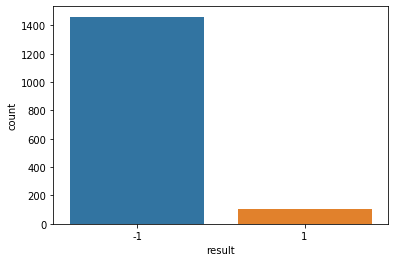

In [21]:
# Display plot of classes in the target variable
sns.countplot(x='result', data=sensor_labels_data)

It is clear we have a class imbalance problem at hand, with significantly more "negative" results (-1) than "positive" results. For every "positive" there are 14 "negatives" (104 to 1462). This is a problem we will have to handle to model the data set. Otherwise, it would be possible for the model simply to guess "negative" and be correct 93% of the time.

## 5. Handle class imbalance problem
Before proceeding we need to address the class imbalance problem inherent in the data set. One way to address the class imbalance problem is through oversampling using a library such as SMOTE.

In [22]:
# Instantiate SMOTE reference
sm = SMOTE(random_state=1)

# Apply oversampling to model data and label column
X_resample, y_resample = sm.fit_resample(sensor_data, sensor_labels_data['result'])

# Convert resampled model data to dataframe and display first rows
df_resample = pd.DataFrame(X_resample, columns=sensor_data.columns)
df_resample.head()

# Convert labels array to dataframe
df_labels_resample = pd.DataFrame(y_resample, columns=['result'])

,s1,s2,s3,s4,s5,s7,s8,s9,s10,s11,...,s577,s578,s583,s584,s585,s586,s587,s588,s589,s590
0,3095.780,2465.140,2230.422,1463.661,0.829,102.343,0.125,1.497,-0.001,-0.015,...,1.107,10.900,0.502,0.022,0.005,4.445,0.010,0.020,0.006,208.204
1,2932.610,2559.940,2186.411,1698.017,1.510,95.488,0.124,1.444,0.004,0.001,...,2.095,9.272,0.496,0.016,0.004,3.175,0.058,0.048,0.015,82.860
2,2988.720,2479.900,2199.033,909.793,1.320,104.237,0.122,1.488,-0.012,-0.003,...,1.758,8.583,0.499,0.010,0.003,2.054,0.020,0.015,0.004,73.843
3,3032.240,2502.870,2233.367,1326.520,1.533,100.397,0.123,1.503,-0.003,-0.007,...,1.660,10.970,0.480,0.477,0.104,99.303,0.020,0.015,0.004,73.843
4,2946.250,2432.840,2233.367,1326.520,1.533,100.397,0.123,1.529,0.017,0.005,...,1.668,13.775,0.495,0.019,0.004,3.828,0.034,0.015,0.005,44.008


Let's see how many rows are now in the data set:

In [23]:
df_resample["s1"].count()

2924

There are now 2924 rows in the data set compared to the 1566 in the original data set. If we examine the distribution of labels, we see a big difference:

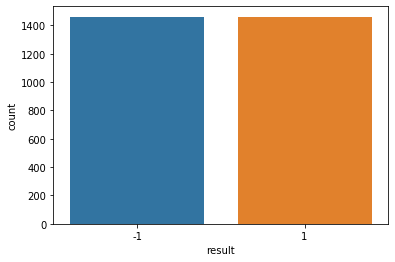

In [24]:
# Display plot of classes in the target variable
sns.countplot(x='result', data=df_labels_resample)

Now there are equal numbers of "positive" and "negative" results. We may now proceed with feature selection.

## 6. Apply feature selection techniques to reduce dimensionality of data
Here we apply feature selection techniques to reduce the dimensionality of data.
### Mutual information score
We begin by computing the mutual information score of each feature against the target variable.

In [25]:
# For each column, apply mutual information computation then sort the results
sorted([calc_MI(df_resample, y_resample, c) for c in df_resample.columns], 
       key=lambda x: x[1],
       reverse=True)

[('s41', 0.114),
 ('s60', 0.079),
 ('s104', 0.069),
 ('s117', 0.066),
 ('s131', 0.066),
 ('s32', 0.063),
 ('s28', 0.062),
 ('s125', 0.06),
 ('s130', 0.058),
 ('s511', 0.057),
 ('s127', 0.056),
 ('s59', 0.055),
 ('s122', 0.055),
 ('s279', 0.055),
 ('s48', 0.054),
 ('s128', 0.054),
 ('s92', 0.05),
 ('s123', 0.05),
 ('s9', 0.048),
 ('s29', 0.047),
 ('s34', 0.047),
 ('s52', 0.047),
 ('s311', 0.047),
 ('s161', 0.045),
 ('s281', 0.045),
 ('s88', 0.043),
 ('s91', 0.043),
 ('s134', 0.042),
 ('s144', 0.042),
 ('s176', 0.042),
 ('s528', 0.042),
 ('s7', 0.041),
 ('s393', 0.041),
 ('s447', 0.041),
 ('s138', 0.04),
 ('s256', 0.04),
 ('s417', 0.04),
 ('s461', 0.04),
 ('s44', 0.039),
 ('s255', 0.039),
 ('s308', 0.039),
 ('s310', 0.039),
 ('s527', 0.039),
 ('s65', 0.038),
 ('s299', 0.038),
 ('s317', 0.038),
 ('s394', 0.038),
 ('s543', 0.038),
 ('s26', 0.037),
 ('s181', 0.037),
 ('s273', 0.037),
 ('s325', 0.037),
 ('s411', 0.037),
 ('s183', 0.036),
 ('s184', 0.036),
 ('s296', 0.036),
 ('s320', 0.036),


Listing the features by mutual information score, we find a number of features at the top, particularly 's41' and 's60', with scores of 0.14 and 0.079 respectively. The top ten features are:
1. s41 (0.114)
1. s60 (0.079)
1. s104 (0.069)
1. s117 (0.066)
1. s131 (0.066)
1. s32 (0.063)
1. s28 (0.062)
1. s125 (0.06)
1. s130 (0.058)
1. s511 (0.057)

### Backward selection
We now perform backward selection to progressively remove the least helpful features until left with a subset of features representing the best predictors of the target variable:

In [26]:
# Perform linear regression on a successively smaller subset of features, 
# pruning less predictive features
estimator = LinearRegression()

# select 5 features, removing 1 feature at a time
back_selector = RFE(estimator, 10, step = 1, verbose = True)
back_selector = back_selector.fit(df_resample, y_resample)

# List the features chosen by backward selection
df_resample.columns[back_selector.support_]

Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
Fitting estimator with 392 features.
Fitting estimator with 391 features.
Fitting estimator with 390 features.
Fitting estimator with 389 features.
Fitting estimator with 388 features.
Fitting estimator with 387 features.
Fitting estimator with 386 features.
Fitting estimator with 385 features.
Fitting estimator with 384 features.
Fitting estimator with 383 features.
Fitting estimator with 382 features.
Fitting estimator with 381 features.
Fitting estimator with 380 features.
Fitting estimator with 379 features.
Fitting estimator with 378 features.
Fitting estimator with 377 features.
Fitting estimator with 376 features.
Fitting estimator with 375 features.
F

Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
F

Index(['s35', 's37', 's58', 's148', 's173', 's175', 's283', 's308', 's310',
       's378'],
      dtype='object')

The features selected by backward selection are:

In [27]:
# List the features chosen by backward selection
df_resample.columns[back_selector.support_]

Index(['s35', 's37', 's58', 's148', 's173', 's175', 's283', 's308', 's310',
       's378'],
      dtype='object')

We analyze any overlap with other feature selection methods below.

### Forward selection
We now perform forward selection to start with the single best feature and progressively add the most helpful features until we have a subset of features that (again) represents the best predictors of the target variable. For performance reasons, we cap the number of features at 20:

In [28]:
# Number of features to use in forward selection
NUMBER_OF_FEATURES = 20

# Perform linear regression on a successively larger subset of features, 
# adding most predictive features
estimator = LinearRegression()

# Scoring set to R-squared
# WARNING: this takes a while!
stepwise_selector = SFS(estimator, 
    k_features = NUMBER_OF_FEATURES, 
    forward = True, 
    floating = False, 
    scoring = 'r2')

stepwise_selector = stepwise_selector.fit(df_resample.values, y_resample)

First we extract the top 10 features:

In [29]:
# Extract the top 10 features
best_features = list(map(int, [x for x in stepwise_selector.get_metric_dict()[10]['feature_names']]))
df_resample.columns[best_features]

Index(['s22', 's34', 's65', 's104', 's125', 's130', 's144', 's189', 's313',
       's438'],
      dtype='object')

The top 10 features based on forward selection are:
1. s22
1. s34
1. s65
1. s104
1. s125
1. s130
1. s144
1. s189
1. s313
1. s438

We now plot the model performance of forward selection:

Text(0.5, 1.0, 'Sequential selection (w. StdErr)')

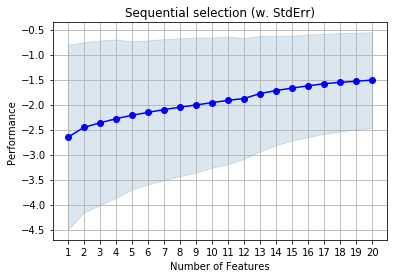

In [30]:
# Plot model performance at each increment
fig = plot_sfs(stepwise_selector.get_metric_dict(), kind = 'std_err')
plt.title('Sequential selection (w. StdErr)')
plt.grid()
plt.show()

The graph shows that performance increases gradually before appear to level off around 18 features.

### LASSO
We now perform feature selection using LASSO, choosing a fairly high alpha to aggressively reduce the number of features selected:

In [34]:
# Set alpha to aggressive value to cut back features
alpha = 4.0

# Apply LASSO regression
clf = linear_model.Lasso(alpha = alpha, tol=0.01)
clf.fit(df_resample, y_resample)

Lasso(alpha=4.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

The bar plot shows that LASSO converges at roughly ten non-negligible features:

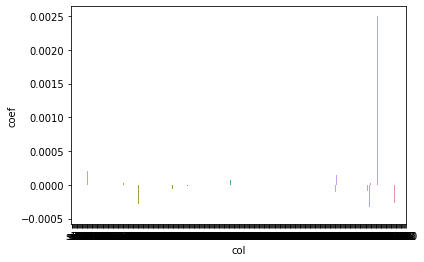

In [35]:
# Display plot of retained coefficients
dd = pd.DataFrame({'col': df_resample.columns, 'coef': clf.coef_})
ax = sns.barplot(x = 'col', y = 'coef', data = dd)

Now we enumerate the features that remain:

In [36]:
# Merge column names and coefficients into single list, taking absolute value of coefficients
retained = list(zip(df_resample.columns[np.where(clf.coef_ != 0)], 
                    map(abs, clf.coef_[np.where(clf.coef_ != 0)])))

# Now sort the list by coefficient absolute value to get the top features
sorted(retained, key=lambda x: x[1], reverse=True)

[('s511', 0.002496236564015313),
 ('s469', 0.00043069904934955487),
 ('s489', 0.0003293353595940339),
 ('s485', 0.0003195993710604432),
 ('s91', 0.00029014625470812587),
 ('s573', 0.0002646311792370096),
 ('s486', 0.00021383690958627253),
 ('s22', 0.00020174560162885936),
 ('s434', 0.000145443800920248),
 ('s433', 0.00010549418728149599),
 ('s484', 8.81399428754087e-05),
 ('s161', 8.186542964443905e-05),
 ('s226', 7.634603103988623e-05),
 ('s4', 7.313186481063623e-05),
 ('s141', 6.873282180046807e-05),
 ('s160', 6.291033549229415e-05),
 ('s490', 2.737711351619466e-05),
 ('s68', 2.2184122920974553e-05),
 ('s24', 2.1595663255198565e-05),
 ('s298', 1.3700716880784587e-05),
 ('s163', 1.1598804073285396e-05),
 ('s162', 9.419785033166562e-06),
 ('s25', 5.491066717303538e-06)]

The top 8 features based on LASSO are:
1. s511
1. s469
1. s489
1. s485
1. s91
1. s573
1. s486
1. s22
1. s434
1. s433

We now examine whether there is any overlap in the features selected by the various methods.

## Initial findings
In lieu of final conclusions we discuss what we have accomplished thus far and the rationale for the various steps we have implemented in preparation for creating a model. In this milestone, we focus on data cleaning and exploration and feature selection.

### Data Exploration and Cleaning
The *secom* data set presents some interesting challenges in terms of missing data. The first problem is columns with NaN. Sixty columns consist of more than 3% NaN "values", which we decided to drop rather than backfill with potentially misleading imputed data. Columns consisting of 3% or less of NaN were cleaned by replacing NaN with the median of the non-NaN values in the the column. A second problem that became apparent during data exporation is columns having zero variance. These columns produced errors when computing the kernel density. With no variance, these variables can contribute nothing to any model and were, hence, eliminated. A third more challenging problem was presented by columns with a substantial percentage of zeros. Since zero is a legitimate value, it is hard to know how much zero in a column indicates that zero in fact represents missing values replaced by a default zero value. In order not to eliminate columns where zero represents a legitimate "null" value, we arbitrarily chose a 20% threshold as the percentage of zeros in a column over which we would consider the zero to represent missing values. So we dropped any columns whose values were more than 20% zeros.

### Feature Selection
We identified the following features per method for feature selection:

| Mutual Information | Backward Selection | Forward Selection | LASSO |
| ---  | ---  | ---  | ---  |
|      |      |  **s22** |  **s22** |
|  s28 |      |      |      |
|  s32 |      |      |      |
|      |      |  s34 |      |
|      |  s35 |      |      |
|      |  s37 |      |      |
|  s41 |      |      |      |
|      |  s58 |      |      |
|  s60 |      |      |      |
|      |      |  s65 |      |
|      |      |      |  s91 |
| **s104** |      | **s104** |      |
| s117 |      |      |      |
| **s125** |      | **s125** |      |
| **s130** |      | **s130** |      |
| s131 |      |      |      |
|      |      | s144 |      |
|      | s148 |      |      |
|      | s173 |      |      |
|      | s175 |      |      |
|      |      | s189 |      |
|      | s283 |      |      |
|      | s308 |      |      |
|      | s310 |      |      |
|      |      | s313 |      |
|      | s378 |      |      |
|      |      |      | s433 |
|      |      |      | s434 |
|      |      | s438 |      |
|      |      |      | s469 |
|      |      |      | s485 |
|      |      |      | s486 |
|      |      |      | s489 |
| **s511** |      |      | **s511** |
|      |      |      | s573 |

It is apparent that there is only limited corroboration between the four methods as to the ten best features to select. Given the large number of features, this is perhaps not too surprising. No features are selected by all four of the methods nor even three of the methods. Five features are selected by two of the methods:

1. s22 (forward selection and LASSO)
1. s104 (mutual information and forward selection)
1. s125 (mutual information and forward selection)
1. s130 (mutual information and forward selection)
1. s511 (mutual information and LASSO)

None of the features selected by backward selection is corroborated by the other methods. Mutual information and forward selection each select four features that are corroborated by another method, though in three of these instances they agree together, which may simply suggest that the two methods are structurally similar or rely on similar underlying criteria.